# Do daily visual checks of data quality
## L. Caffarello, July 2022
### Updates by A. Ordog, August-September 2022
### August 25, 2022 (AO): 
#### - changed filenames to account for survey phases
#### - changed frequency channels read in to all channels (instead of every 12th)
#### - included 5 MHz to each side of the central frequency in the single-scan, 1D timeseries plots
#### - included persistent RFI mask indication (grey background) on timeseries plots
### September 12, 2022 (AO):
#### - option to mask out persistent RFI
#### - indicate elevation of scans
#### - scan IDs indicated in waterfall plot columns

## Import packages:

In [1]:
# import dva_sdhdf_combine
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from ipywidgets import interact
from ipywidgets import fixed
from ipywidgets import interactive_output
from astropy.coordinates import SkyCoord,EarthLocation, AltAz, ICRS, Galactic, FK4, FK5

#### Change the directory to where the files are located" ####
day ='18'
#directory = '/srv/data/dva/survey_azimuth_scans/'
#directory = '/srv/data/dva/survey_azimuth_scans/day_45_lightning/'
#directory = '../DVA/Data_Files/DVA_Day_Surveys/'
directory = '/media/ordoga/15m_band1_survey/dva_phase1/survey_phase1_day'+day+'/'

#TODO: actually do the scan properties definition in the beginning
##############################################################

## Read in the file listing azimuth scan start and stop times:

In [2]:
scan_id = []    # The scan id number
scan_start = []  # Start time of the scan (UTC)
scan_stop = []   # Stop time of the scan (UTC)
scan_el = []

# Read in the data and store it in arrays:
with open(directory+'DVAsurvey_phase1_day0'+day+'.txt') as fp:
    for line in fp:       
        scan_id.append(int(line.split()[0]))
        scan_start.append(line.split()[1]+'T'+line.split()[2][0:12])
        scan_stop.append(line.split()[3]+'T'+line.split()[4][0:12])
        scan_el.append(line.split()[5][0:2])
        
# Print out the scan numbers with their start and stop times:
for i in range(0,len(scan_id)):
    print(f"{scan_id[i]:04}",scan_start[i],scan_stop[i],scan_el[i])

# Convert start and stop times to Modified Julian Day (MJD).
# This is needed for plotting and for selecting out data collected
# between particular times:
scan_start_mjd = Time(scan_start, format='isot',scale='utc').mjd
scan_stop_mjd  = Time(scan_stop,  format='isot',scale='utc').mjd


0403 2022-06-26T03:51:38.798 2022-06-26T04:09:40.619 49
0404 2022-06-26T04:11:23.637 2022-06-26T04:29:26.014 49
1917 2022-06-26T04:34:07.894 2022-06-26T04:52:09.910 20
0622 2022-06-26T04:57:28.156 2022-06-26T05:15:30.553 49
2135 2022-06-26T05:20:12.111 2022-06-26T05:38:14.289 20
2136 2022-06-26T05:39:57.192 2022-06-26T05:57:59.092 20
2137 2022-06-26T05:59:41.747 2022-06-26T06:17:43.566 20
0842 2022-06-26T06:23:02.211 2022-06-26T06:41:03.989 49
0843 2022-06-26T06:42:46.735 2022-06-26T07:00:48.572 49
2356 2022-06-26T07:05:30.983 2022-06-26T07:23:33.286 20
1061 2022-06-26T07:28:51.368 2022-06-26T07:46:53.620 49
1062 2022-06-26T07:48:36.072 2022-06-26T08:06:38.193 49
1063 2022-06-26T08:08:56.419 2022-06-26T08:26:58.566 49
2576 2022-06-26T08:31:40.664 2022-06-26T08:49:42.748 20
1281 2022-06-26T08:54:25.045 2022-06-26T09:12:27.211 49
1282 2022-06-26T09:14:45.597 2022-06-26T09:32:47.745 49
1283 2022-06-26T09:34:30.746 2022-06-26T09:52:32.956 49
2796 2022-06-26T09:57:14.811 2022-06-26T10:15:17

## Read in scan files and stich them together:

In [3]:
t_set = []
az_set = []
dec_set = []
ra_set = []
el_set = []
noise_set = []
trim_flag = []

scan0 = f"{scan_id[0]:04}"

freq_channel_increment = 1 #TODO: I'll have to change this to 1 once I am sure I'm reading the data correctly

# Use one of the scans to get the list of frequencies:
file = h5py.File(directory+'dva_survey_phase1_raw_'+scan0+'.h5','r')
freq = file['data']['beam_0']['band_SB0']['frequency'][::freq_channel_increment]/1e6

# Create empty arrays for the power data:
RR_set = np.empty([0,len(freq)])
LL_set = np.empty([0,len(freq)])
reRL_set = np.empty([0,len(freq)])
imRL_set = np.empty([0,len(freq)])

# Loop through all the scans in the "scan_num" list:
for i in scan_id:
#for i in scan_id[0:5]:
    print(i)
    # select the file:
    file = h5py.File(directory+'dva_survey_phase1_raw_'+f"{i:04}"+'.h5','r')
    print(file)
    
    # access the correct location in the file structure:
    dataset = file['data']['beam_0']['band_SB0']['scan_0']
    
    # Add the position and time data to the corresponding arrays:
    dec_set = np.concatenate([dec_set,dataset['metadata']['declination']])
    ra_set = np.concatenate([ra_set,dataset['metadata']['right_ascension']])
    el_set = np.concatenate([el_set,dataset['metadata']['elevation']])
    az_set = np.concatenate([az_set,dataset['metadata']['azimuth']])
    t_set = np.concatenate([t_set,dataset['metadata']['utc']])
    noise_set = np.concatenate([noise_set,dataset['metadata']['noise_state']]) #This is a "mask" for noise regions 1 = noise 0=all good
    trim_flag = np.concatenate([trim_flag,dataset['metadata']['trim_scan_flag']])
    
    # Add the spectrometer power data to the corresponding arrays:
    RR_set = np.concatenate([RR_set,dataset['data'][:,0,::freq_channel_increment]],axis=0)
    LL_set = np.concatenate([LL_set,dataset['data'][:,1,::freq_channel_increment]],axis=0)
    reRL_set = np.concatenate([reRL_set,dataset['data'][:,2,::freq_channel_increment]],axis=0)
    imRL_set = np.concatenate([imRL_set,dataset['data'][:,3,::freq_channel_increment]],axis=0)
    
t_plt = Time(t_set, format='isot',scale='utc').mjd

403
<HDF5 file "dva_survey_phase1_raw_0403.h5" (mode r)>
404
<HDF5 file "dva_survey_phase1_raw_0404.h5" (mode r)>
1917
<HDF5 file "dva_survey_phase1_raw_1917.h5" (mode r)>
622
<HDF5 file "dva_survey_phase1_raw_0622.h5" (mode r)>
2135
<HDF5 file "dva_survey_phase1_raw_2135.h5" (mode r)>
2136
<HDF5 file "dva_survey_phase1_raw_2136.h5" (mode r)>
2137
<HDF5 file "dva_survey_phase1_raw_2137.h5" (mode r)>
842
<HDF5 file "dva_survey_phase1_raw_0842.h5" (mode r)>
843
<HDF5 file "dva_survey_phase1_raw_0843.h5" (mode r)>
2356
<HDF5 file "dva_survey_phase1_raw_2356.h5" (mode r)>
1061
<HDF5 file "dva_survey_phase1_raw_1061.h5" (mode r)>
1062
<HDF5 file "dva_survey_phase1_raw_1062.h5" (mode r)>
1063
<HDF5 file "dva_survey_phase1_raw_1063.h5" (mode r)>
2576
<HDF5 file "dva_survey_phase1_raw_2576.h5" (mode r)>
1281
<HDF5 file "dva_survey_phase1_raw_1281.h5" (mode r)>
1282
<HDF5 file "dva_survey_phase1_raw_1282.h5" (mode r)>
1283
<HDF5 file "dva_survey_phase1_raw_1283.h5" (mode r)>
2796
<HDF5 file "dv

## Polarized Intensity

In [18]:
polarized = []
for i,j in zip(reRL_set,imRL_set):
    PI = np.sqrt((i**2)+(j**2))
    polarized.append(PI)
polarized_plot = np.array(polarized)

#print(LL_set)
print("LL_set:", np.shape(LL_set))
print(" t_plt:", np.shape(t_plt))
print("  freq:", np.shape(freq))

LL_set: (41484, 8250)
 t_plt: (41484,)
  freq: (8250,)


## Read in persistent RFI mask

In [4]:
i = 0
RFI_mask_idx = []
#with open('/srv/data/dva/RFIpersist_mask/RFIpersist_mask.txt') as fp:
with open('../DVA2/DATA/PersistRFI_v01_Jul13.txt') as fp:
    for line in fp:
        if i>0: 
            #print(line)
            RFI_mask_idx.append(int(line.split()[0]))
        i=i+1

In [6]:
data = np.load('../DVA2/DATA/Daily_maps/survey_phase1_upto_day47.npy',allow_pickle=True)

RR_map = data[0].astype(float)
LL_map = data[1].astype(float)
reRL_map = data[2].astype(float)
imRL_map = data[3].astype(float)
ra_map = data[4].astype(float)
dec_map = data[5].astype(float)
az_map = data[6].astype(float)
el_map = data[7].astype(float)
t_map = data[8].copy()
noise_map = data[9].astype(float)
t_map_plt = data[10].astype(float)
day_array = data[11]
#scan_id = data[12]
#scan_start = data[13]
#scan_stop = data[14]
freq_map = data[15]
ra_map_deg = ra_map*360./24.

wbad = np.where(noise_map == 1.0)
RR_map[wbad] = np.nan
LL_map[wbad] = np.nan
reRL_map[wbad] = np.nan
imRL_map[wbad] = np.nan

In [7]:
%%time
loc = EarthLocation(lat = 49.3*u.deg, lon = -119.6*u.deg, height = 546*u.m)

wgood = np.where(np.isfinite(el_map))

AltAzcoord = SkyCoord(alt=el_map[wgood]*u.deg, az=az_map[wgood]*u.deg, 
                      obstime=Time(t_map[wgood],format='isot',scale='utc',location=loc),
                      frame = 'altaz', location = loc)

ra = AltAzcoord.icrs.ra.deg
dec = AltAzcoord.icrs.dec.deg

l = AltAzcoord.galactic.l.deg
b = AltAzcoord.galactic.b.deg

CPU times: user 11min 20s, sys: 4.9 s, total: 11min 24s
Wall time: 11min 24s


## Updated visualization, including single-scan option
### Changes made by AO:
#### - power bounds in dB to see lower power signal
#### - changed to log scale and added RR to time series plots and spectra
#### - added grids to 1D plots
#### - added option for single-scan plots (both waterfall and 1D)

In [5]:
df = freq[1]-freq[0]
power_min = 65
power_max = 79
fs = 14

def DVA_Waterfall_View(RFI_masked):  
    
    #TODO: implement toggling between RR, LL,reRL, imRL
       
    fig,axs = plt.subplots(1,1,figsize=(15,10)) 
    
    for i in range(0,len(scan_id)):
        w = np.where((t_plt>=scan_start_mjd[i]) & (t_plt<=scan_stop_mjd[i]))[0]
        extent = [scan_start_mjd[i],scan_stop_mjd[i],freq[0],freq[-1]]
        
        if scan_el[i] == '49':
            textclr = 'blue'
        else:
            textclr = 'red'
                
        data_plot = 10*np.log10(LL_set[w,:].T)
        if RFI_masked:
            data_plot[RFI_mask_idx,:] = np.nan
    
        im = axs.imshow(data_plot,aspect='auto',vmin=power_min,vmax=power_max,
                        origin='lower',extent=extent,cmap='viridis')

        axs.text(scan_start_mjd[i]+3e-3,1038,f"{scan_id[i]:04}",rotation=45,fontsize=fs,color=textclr)
    
    divider = make_axes_locatable(axs)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_label('Power (dB)', fontsize=fs)

    axs.set_xlim(t_plt[0],t_plt[-1])
    axs.set_ylim(freq[0],freq[-1])
    axs.tick_params(axis='both', labelsize=fs)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs.set_xlabel('Time (UTC)',fontsize=fs)        
    axs.set_ylabel('Frequency (MHz)',fontsize=fs)
    
    return

def DVA_Waterfall_View_singlescan(scan_chosen, RFI_masked):
    
    #print(axmap)
    #TODO: implement toggling between RR, LL,reRL, imRL
    scan_id_plot = scan_chosen
    scan_idx = np.where(np.array(scan_id) == scan_id_plot)    
    w = np.where((t_plt>=scan_start_mjd[scan_idx]) & (t_plt<=scan_stop_mjd[scan_idx]))[0]
    
    #loc = EarthLocation(lat = 49.3*u.deg, lon = -119.6*u.deg, height = 546*u.m)
    #AltAzcoord = SkyCoord(alt=el_set[w]*u.deg, az=az_set[w]*u.deg, 
    #                  obstime=Time(t_set[w],format='isot',scale='utc',location=loc),
    #                  frame = 'altaz', location = loc)
    #l_scan = AltAzcoord.galactic.l.deg
    #b_scan = AltAzcoord.galactic.b.deg
    #print(l_scan)
    #print(b_scan)
    #gal_scan = SkyCoord(l_scan, b_scan, frame='galactic', unit=u.deg)
    #axmap.scatter(-gal_scan.l.wrap_at('180d').radian, gal_scan.b.radian,s=100,color='black',zorder=1000)
    #axmap.scatter(-30*np.pi/180, 0,s=100,color='black',zorder=1000)
        
    fig,axs = plt.subplots(1,1,figsize=(15,10))     
    extent = [scan_start_mjd[scan_idx][0],scan_stop_mjd[scan_idx][0],freq[0],freq[-1]]
    
    data_plot = 10*np.log10(LL_set[w,:].T)
    if RFI_masked:
        data_plot[RFI_mask_idx,:] = np.nan
    
    im = axs.imshow(data_plot,aspect='auto',vmin=power_min,vmax=power_max,
                    origin='lower',extent=extent,cmap='viridis')

    divider = make_axes_locatable(axs)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_label('Power (dB)', fontsize=fs)

    axs.set_xlim(extent[0],extent[1])
    axs.set_ylim(freq[0],freq[-1])
    axs.tick_params(axis='both', labelsize=fs)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs.set_xlabel('Time (UTC)',fontsize=fs)        
    axs.set_ylabel('Frequency (MHz)',fontsize=fs)
    axs.set_title('Scan '+str(scan_id_plot)+' , el = '+str(scan_el[scan_idx[0][0]]),fontsize=fs)
    
    return


def DVA_Cross_Sections(freq_chosen, time_idx, freq_cross_section,RFI_masked):
    
    freq_measured = np.where(abs(freq-freq_chosen)<df)[0][0]
    freq_below = np.where((freq>freq_chosen-5) & (freq<freq_chosen))[0]
    freq_above = np.where((freq<freq_chosen+5) & (freq>freq_chosen))[0]
   
    fig,axs1 = plt.subplots(1,1,figsize=(16,6))  

    if(freq_cross_section):
        
        data_plot_L = 10*np.log10(LL_set[time_idx,:])
        data_plot_R = 10*np.log10(RR_set[time_idx,:])
        
        if RFI_masked:
            data_plot_L[RFI_mask_idx] = np.nan
            data_plot_R[RFI_mask_idx] = np.nan

        axs1.plot(freq,data_plot_L,label='LL',color='blue')
        axs1.plot(freq,data_plot_R,label='RR',color='red')        
        axs1.vlines(freq_chosen, 0 , 100e9, color = 'purple')
        axs1.set_ylim(power_min,power_max) 
        axs1.set_xlim(350,1050)
        axs1.set_xlabel('Frequency',fontsize=fs)
        axs1.tick_params(axis='both',labelsize=fs)
    else:
        axs1.scatter(t_plt, 10*np.log10(LL_set[:,freq_measured]),label='LL',s=0.8,zorder=1,color='blue')
        axs1.scatter(t_plt, 10*np.log10(RR_set[:,freq_measured]),label='RR',s=0.8,zorder=1,color='red')
          
        axs1.vlines(t_plt[time_idx], 0 , 100e9, color = 'purple')
        
        for i in range(0,len(scan_id)):
            if scan_el[i] == '49':
                elclr = 'C0'
            else:
                elclr = 'C1'        
            axs1.axvspan(scan_start_mjd[i],scan_stop_mjd[i],color=elclr,alpha=0.2,zorder=0)
            axs1.text(scan_start_mjd[i]+3e-3,power_max+0.5,f"{scan_id[i]:04}",rotation=45,fontsize=fs)

        axs1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs1.set_ylim(power_min,power_max)
        axs1.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs1.set_xlabel('Time (UTC)',fontsize=fs)
        axs1.set_xlim(t_plt[0],t_plt[-1])
        axs1.tick_params(axis='both',labelsize=fs)
        axs1.tick_params(axis='both',labelsize=fs)
        
        if freq_measured in RFI_mask_idx:
            axs1.set_facecolor('lightgray')        
        
    axs1.set_ylabel('Power',fontsize=fs)
    axs1.legend(fontsize=fs,markerscale=5)
    axs1.grid()
    
    return

    
def DVA_Cross_Sections_singlescan(freq_chosen,scan_chosen,RFI_masked,freq_cross_section,time_idx):
    
    freq_measured = np.where(abs(freq-freq_chosen)<df)[0][0]
    freq_below = np.where((freq>freq_chosen-5) & (freq<freq_chosen))[0]
    freq_above = np.where((freq<freq_chosen+5) & (freq>freq_chosen))[0]
    #print(freq[freq_measured],freq[freq_range])
          
    scan_id_plot = scan_chosen
    scan_idx = np.where(np.array(scan_id) == scan_id_plot)
    
    w = np.where((t_plt>=scan_start_mjd[scan_idx]) & (t_plt<=scan_stop_mjd[scan_idx]))[0]
         
    fig,axs1 = plt.subplots(1,1,figsize=(16,6)) 
            
    if(freq_cross_section):
            
        data_plot_L = 10*np.log10(LL_set[w[time_idx],:])
        data_plot_R = 10*np.log10(RR_set[w[time_idx],:])
        
        if RFI_masked:
            data_plot_L[RFI_mask_idx] = np.nan
            data_plot_R[RFI_mask_idx] = np.nan
            
        axs1.plot(freq,data_plot_L, label='LL',color='blue')
        axs1.plot(freq,data_plot_R, label='RR',color='red')
        axs1.vlines(freq_chosen, 0 , 100e9, color = 'purple')
        axs1.set_ylim(power_min,power_max)
        axs1.set_xlim(350,1030)
        axs1.set_xlabel('Frequency',fontsize=fs)
        axs1.tick_params(axis='both',labelsize=fs)
    else:
        axs1.plot(t_plt[w], 10*np.log10(LL_set[w,freq_measured]), label='LL',color='blue',zorder=1)
        axs1.plot(t_plt[w], 10*np.log10(RR_set[w,freq_measured]), label='RR',color='red',zorder=1)
        for ifreq in freq_above:
            axs1.plot(t_plt[w], 10*np.log10(LL_set[w,ifreq]), alpha=0.5,color='C0',zorder=0)
            axs1.plot(t_plt[w], 10*np.log10(RR_set[w,ifreq]), alpha=0.5,color='C1',zorder=0)
        for ifreq in freq_below:
            axs1.plot(t_plt[w], 10*np.log10(LL_set[w,ifreq]), alpha=0.5,color='C9',zorder=0)
            axs1.plot(t_plt[w], 10*np.log10(RR_set[w,ifreq]), alpha=0.5,color='salmon',zorder=0)
        axs1.vlines(t_plt[w][time_idx], 0 , 100e9, color = 'purple')

        axs1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs1.set_ylim(power_min,power_max) #AO changed this to log scale limits
        axs1.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs1.set_xlabel('Time (UTC)',fontsize=fs)
        axs1.set_xlim(t_plt[w][0],t_plt[w][-1])
        axs1.tick_params(axis='both',labelsize=fs)
        axs1.set_title('Scan '+str(scan_id_plot)+' , el = '+str(scan_el[scan_idx[0][0]]),fontsize=fs)
            
        if freq_measured in RFI_mask_idx:
             axs1.set_facecolor('lightgray')
        
    axs1.set_ylabel('Power',fontsize=fs)
    axs1.legend(fontsize=fs,markerscale=5)
    axs1.grid()
    
    return
    
def make_map(l,b,LL_map,wgood):

    frq_idx = 1
    data_plot = 10*np.log10(LL_map[wgood,frq_idx])
    fs=12
    Pmin = 69.5
    Pmax = 72
    spts = 1

    gal = SkyCoord(l, b, frame='galactic', unit=u.deg)
    
    
    figmap,axmap = plt.subplots(1,1,figsize=(14,7), subplot_kw={'projection': 'aitoff'})
    #fig = plt.figure(figsize=(14,7))
    #plt.subplot(111, projection='aitoff')
    axmap.grid(True)
    axmap.scatter(-gal.l.wrap_at('180d').radian, gal.b.radian,s=spts,c=data_plot,vmin=Pmin,vmax=Pmax,alpha=0.4)
    positions = (-150*np.pi/180.,-120*np.pi/180.,-90*np.pi/180.,-60*np.pi/180.,-30*np.pi/180.,0,
                 30*np.pi/180.,60*np.pi/180.,90*np.pi/180.,120*np.pi/180.,150*np.pi/180.)
    labels = ("150","120","90","60","30","0","330","300","270","240","210")
    axmap.set_xticks(ticks=positions)
    #axmap.set_yticks()
    axmap.set_xlabel('Galactic Longitude (degrees)',fontsize=fs)
    axmap.set_ylabel('Galactic Latitude (degrees)',fontsize=fs)
    #plt.title('LL, 800 MHz',fontsize=fs)
    print(axmap)
    #plt.show(block=False)
    
#def draw_scan_track():
    return figmap,axmap
    
        
def DVA_Visualization(waterfall_enabled,singlescan):
    #plt.plot(axs=axmap)
    #axmap.scatter(-30*np.pi/180, 0,s=100,color='black',zorder=1000)
    if waterfall_enabled:
        if singlescan:
            interact(DVA_Waterfall_View_singlescan,scan_chosen = scan_id, RFI_masked = False)
        else:
            interact(DVA_Waterfall_View, RFI_masked = False)
    else:
        if singlescan:
            #axmap = make_map(l,b,LL_map,wgood)
            interact(DVA_Cross_Sections_singlescan, freq_chosen = (350, 1030, df), 
                     scan_chosen = scan_id, RFI_masked = False, freq_cross_section = False,
                    time_idx = (0,1802))
        else:
            interact(DVA_Cross_Sections, freq_chosen = (350, 1030, df), 
                     freq_cross_section = False, time_idx = (0,len(t_plt)-1), RFI_masked = False)
            
    return

In [6]:
interact(DVA_Visualization,waterfall_enabled = True, singlescan = True)


interactive(children=(Checkbox(value=True, description='waterfall_enabled'), Checkbox(value=True, description=…

<function __main__.DVA_Visualization(waterfall_enabled, singlescan)>

AxesSubplot(0.125,0.125;0.775x0.755)


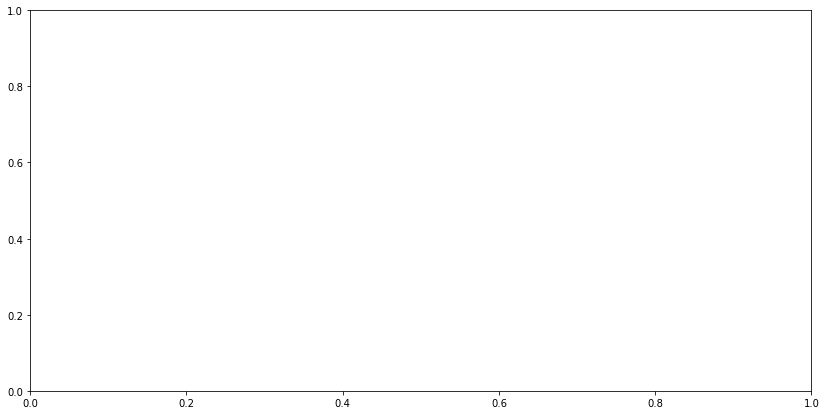

In [117]:
fig,ax2 = plt.subplots(1,1,figsize=(14,7))
print(ax2)

## Leo's original code:

In [ ]:
df = freq[1]-freq[0]

def DVA_Waterfall_View():
    #TODO: Add another DVA_Waterfall interactive_function such that I can change between LL_Set, RR_set, etc...
    power_min = 66 #AO changed from 70
    power_max = 78

    fig,axs = plt.subplots(1,1,figsize=(15,10)) 
    fs = 16
    
    for i in range(0,len(scan_id)):
        w = np.where((t_plt>=scan_start_mjd[i]) & (t_plt<=scan_stop_mjd[i]))[0]
        extent = [scan_start_mjd[i],scan_stop_mjd[i],freq[0],freq[-1]]
    
        im = axs.imshow(10*np.log10(LL_set[w,:].T),aspect='auto',vmin=power_min,vmax=power_max,
                        origin='lower',extent=extent,cmap='viridis')
    
    #im = axs.imshow(10.*np.log10(LL_set.T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
    #            extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])

    divider = make_axes_locatable(axs)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=fs) 
    cbar.set_label('Power (dB)', fontsize=fs)

    axs.set_xlim(t_plt[0],t_plt[-1])
    axs.set_ylim(freq[0],freq[-1])
    axs.tick_params(axis='both', labelsize=fs)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs.set_xlabel('Time (UTC)',fontsize=fs)        
    axs.set_ylabel('Frequency (MHz)',fontsize=fs)


def DVA_Cross_Sections(freq_chosen, time_idx, freq_cross_section):
    freq_measured = np.where(abs(freq-freq_chosen)<df)[0][0]

    fs = 12    
    fig,axs1 = plt.subplots(1,1,figsize=(16,6))  
    # TODO: use the log of LL_set_clean
    if(freq_cross_section):
        power_min = 66 #AO added limits
        power_max = 78
        # AO changed to log scale and added RR:
        axs1.plot(freq,10*np.log10(LL_set[time_idx,:]), label='LL')
        axs1.plot(freq,10*np.log10(RR_set[time_idx,:]), label='RR')
        axs1.vlines(freq_chosen, 0 , 100e9, color = 'red')
        axs1.set_ylim(power_min,power_max) #AO changed this to log scale limits
        axs1.set_xlim(350,1050)
        #axs1.set_ylim(np.min(LL_set[:,freq_measured]), np.max(LL_set[time_idx,:]))
        axs1.set_xlabel('Frequency',fontsize=fs)
    else:
        power_min = 66 #AO added limits
        power_max = 78
        # AO changed to log scale and added RR:
        axs1.scatter(t_plt, 10*np.log10(LL_set[:,freq_measured]), label='LL',s=0.5)
        axs1.scatter(t_plt, 10*np.log10(RR_set[:,freq_measured]), label='RR',s=0.5)
        axs1.vlines(t_plt[time_idx], 0 , 100e9, color = 'red')

        axs1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs1.set_ylim(power_min,power_max) #AO changed this to log scale limits
        axs1.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs1.set_xlabel('Time (UTC)',fontsize=fs)
        axs1.set_xlim(t_plt[0],t_plt[-1])
    axs1.set_ylabel('Power',fontsize=fs)
    axs1.legend()
    axs1.grid() # AO added grid

def DVA_Visualization(waterfall_enabled):
    if waterfall_enabled:
        interact(DVA_Waterfall_View)
    else:
        interact(DVA_Cross_Sections, freq_chosen = (350, 1000, df), freq_cross_section = False, time_idx = (0,len(t_plt)-1))


interact(DVA_Visualization, waterfall_enabled = True)

#TODO: plot power in DB